 # ECS708P MiniProject, Anuja Jyothi Vijayakumar, 190211413

#  Basic Solution


##  Brief summary

The following classifiers are tried for Basic Solution
1. KNeighborsClassifier
2. SVC with kernel as linear and rbf, and C as 0.025
4. DecisionTreeClassifier with and without the parameter max_depth=5
5. RandomForestClassifier with and without the parameters max_depth=5, n_estimators=10 and  max_features=1
6. AdaBoostClassifier
7. GaussianNB
8. QuadraticDiscriminantAnalysis

The features of all the audio files are extracted during the feature extraction. The additional features other than "Power", "Pitch mean", "Pitch standard deviation" and "Fraction of voiced region" include:

1. zero crossing rate
2. spectral centroid
3. spectral rolloff
4. zero crossings
5. mfccs 
 
Multiple hyperparameters are tried and based on the best outcome the model was selected. The selected model is validated on the validation dataset. 


In [120]:
from google.colab import drive


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, sys, re, pickle, glob
import IPython.display as ipd
import librosa
import librosa.display
import soundfile
import urllib.request
import zipfile

from tqdm import tqdm
from datetime import datetime 
from scipy.io import wavfile as wav

from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint 

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset preparation

### Environment set up

In this section we will set up a Colab environment for the MLEnd mini-project. Before starting, follow these simple instructions: 

1.   Go to https://drive.google.com/
2.   Create a folder named 'Data' in 'MyDrive'. On the left, click 'New' > 'Folder', enter the name 'Data', and click 'create'
3.   Open the 'Data' folder and create a folder named 'MLEnd'.
4.   Move the file 'trainingMLEnd.csv' to the newly created folder 'MyDrive/Data/MLEnd'.



Run the following cell to check that the MLEnd folder contains the file 'trainingMLEnd,csv':

In [121]:
path = '/content/drive/MyDrive/Data/MLEnd'
os.listdir(path)

['trainingMLEnd.csv', '.ipynb_checkpoints', 'training.zip', 'training']

### Data download
In this section we will download the data that you need to build your solutions. Note that even though we call it "training" dataset you can do whatever you want with it, for instance validation tasks. Note that we keep a separate dataset for testing purposes, which we won't share with anyone.

First, we will define a function that will allow us to download a file into a chosen location.

In [122]:
#def download_url(url, save_path):
#    with urllib.request.urlopen(url) as dl_file:
#        with open(save_path, 'wb') as out_file:
#            out_file.write(dl_file.read())

The next step is to download the file 'training.zip' into the folder 'MyDrive/Data/MLEnd'. Note that this might take a while.

In [123]:
#url  = "https://collect.qmul.ac.uk/down?t=6H8231DQL1NGDI9A/613DLM2R3OFV5EEH9INK2OG"
#save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'
#download_url(url, save_path)

In [124]:
#from google.colab import drive
#drive.mount('/content/drive')

Finally, let's unzip the training file.

In [125]:
#directory_to_extract_to = '/content/drive/MyDrive/Data/MLEnd/training/'
#with zipfile.ZipFile(save_path, 'r') as zip_ref:
#    zip_ref.extractall(directory_to_extract_to)

Once this step is completed, you should have all the audio files in the location 'MyDrive/Data/MLEnd/training/training'. 

### Understanding our dataset

Let's check how many audio files we have in our training dataset:

In [126]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

20000

This figure (20k) corresponds to the number of **items** or **samples** in our dataset. Let's listen to some random audio files:

In [127]:
# five random files
for _ in range(5):
  n = np.random.randint(20000)
  display(ipd.Audio(files[n]))

Can you recognise the numeral and intonation? Can you recognise the speaker?

Let's now load the contents of 'trainingMLEnd.csv' into a pandas DataFrame and explore them:

In [128]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


This file consists of 20k rows and 4 columns. Each row corresponds to one of the items in our dataset, and each item is described by four attributes:


1.   File ID (audio file)
2.   Numeral
3.   Participand ID
4.   Intonation

Could you explore this dataset further and identify how many items we have per numeral, per individual and per intonation?

## Dataset visualisation

A numeral is picked to visualize and compare the waveforms of "Bored", "Excited", "Neutral" and "Question" intonations. For this example visualization digit "2" is used, four samples per intonation. There is visible difference even for the same intonation by different participants. This is an early observation to get an idea of how much the prediction may divert from the ground truths. 

A similar visualization is performed by the combination of power spectrograms output by STFT w.r.t time. Visually they seem to be close and identical to each other.  Thus we can see an expected balance in the prediction of these intonations.

The number of numerals and the number of recordings per participant is a also visualized.

The distributions of audio among the different intonations is visualized using plot, and they seem to be more or less evenly distributed

In [129]:
labels_df = pd.DataFrame(labels)
labels_df.loc[(labels_df['intonation'] == "bored") & (labels_df['digit_label'] == 2)]
labels_df.loc[(labels_df['intonation'] == "excited") & (labels_df['digit_label'] == 2)]
labels_df.loc[(labels_df['intonation'] == "neutral") & (labels_df['digit_label'] == 2)]
labels_df.loc[(labels_df['intonation'] == "question") & (labels_df['digit_label'] == 2)]

,File ID,digit_label,participant,intonation
136,0000136.wav,2,S86,question
558,0000558.wav,2,S75,question
778,0000778.wav,2,S109,question
857,0000857.wav,2,S129,question
944,0000944.wav,2,S89,question
...,...,...,...,...
19601,0019601.wav,2,S5,question
19643,0019643.wav,2,S2,question
19762,0019762.wav,2,S80,question
19894,0019894.wav,2,S99,question


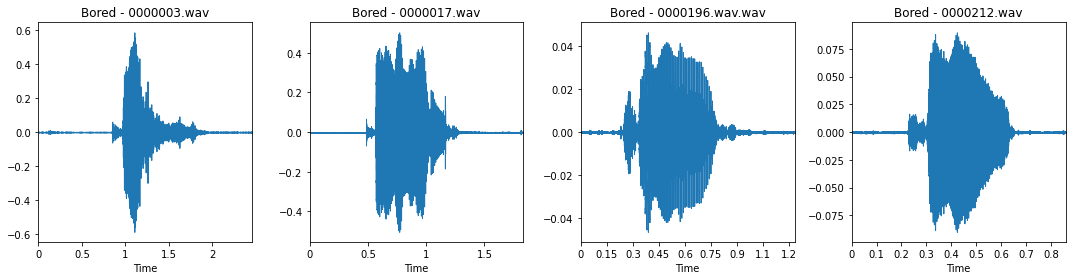

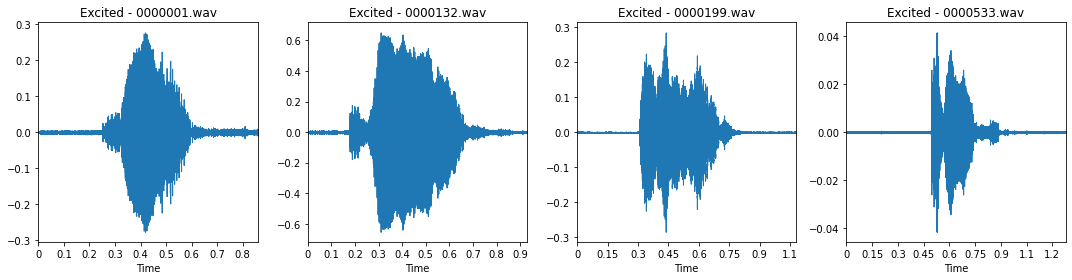

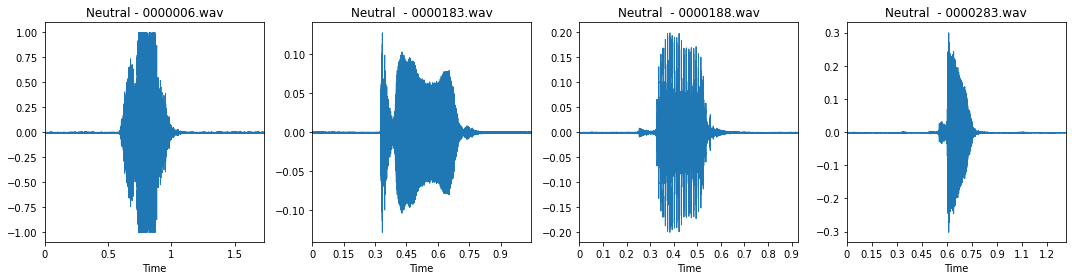

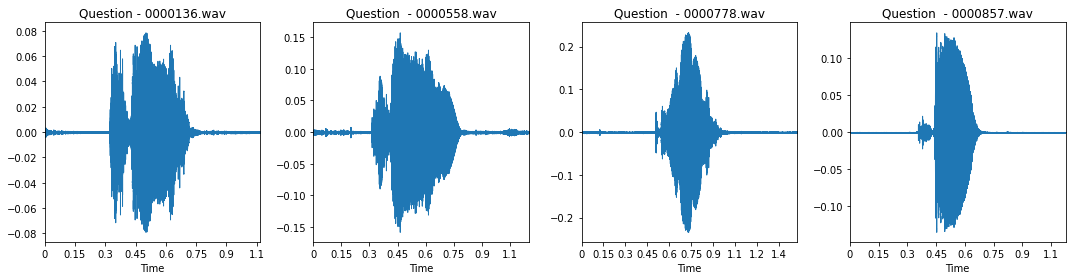

In [130]:
with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000003.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.figure(figsize=(15,4))
    plt.subplot(1, 4, 1)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Bored - 0000003.wav')
    plt.tight_layout()
   
with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000017.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(1, 4, 2)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Bored - 0000017.wav')
    plt.tight_layout()

with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000196.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(1, 4, 3)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Bored - 0000196.wav.wav')
    plt.tight_layout()
    
with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000212.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(1, 4, 4)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Bored - 0000212.wav') 
    plt.tight_layout()   

#############################################################################################################

with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000001.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.figure(figsize=(15,4))
    plt.subplot(1, 4, 1)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Excited - 0000001.wav')
    plt.tight_layout()
   
with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000132.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(1, 4, 2)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Excited - 0000132.wav')
    plt.tight_layout()

with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000199.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(1, 4, 3)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Excited - 0000199.wav')
    plt.tight_layout()
    
with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000533.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(1, 4, 4)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Excited - 0000533.wav') 
    plt.tight_layout()   

#############################################################################################################

with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000006.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.figure(figsize=(15,4))
    plt.subplot(1, 4, 1)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Neutral - 0000006.wav')
    plt.tight_layout()
   
with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000183.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(1, 4, 2)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Neutral  - 0000183.wav')
    plt.tight_layout()

with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000188.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(1, 4, 3)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Neutral  - 0000188.wav')
    plt.tight_layout()
    
with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000283.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(1, 4, 4)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Neutral  - 0000283.wav') 
    plt.tight_layout()   
    
#############################################################################################################

with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000136.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.figure(figsize=(15,4))
    plt.subplot(1, 4, 1)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Question - 0000136.wav')
    plt.tight_layout()
   
with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000558.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(1, 4, 2)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Question  - 0000558.wav')
    plt.tight_layout()

with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000778.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(1, 4, 3)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Question  - 0000778.wav')
    plt.tight_layout()
    
with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000857.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(1, 4, 4)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Question  - 0000857.wav') 
    plt.tight_layout()   

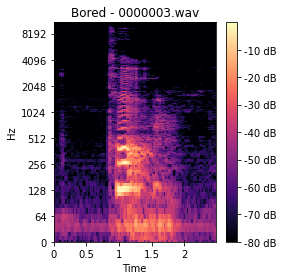

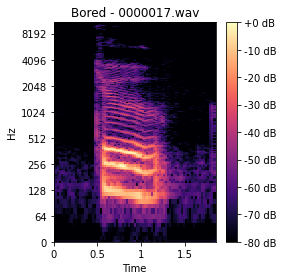

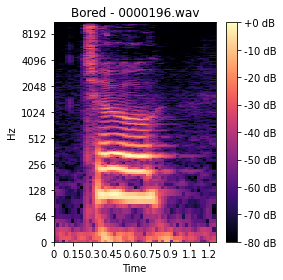

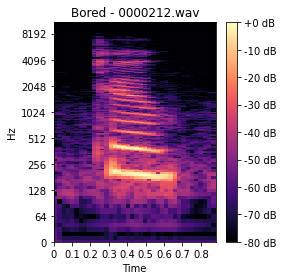

In [131]:
with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000003.wav') as audio:
    bored_waveform_03 = audio.read(dtype="float32")
    sample_rate = audio.samplerate

stft_spectrum_matrix = librosa.stft(bored_waveform_03)
plt.figure(figsize=(4, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Bored - 0000003.wav')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000017.wav') as audio:
    bored_waveform_17 = audio.read(dtype="float32")
    sample_rate = audio.samplerate

stft_spectrum_matrix = librosa.stft(bored_waveform_17)
plt.figure(figsize=(4, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Bored - 0000017.wav')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000196.wav') as audio:
    bored_waveform_196 = audio.read(dtype="float32")
    sample_rate = audio.samplerate

stft_spectrum_matrix = librosa.stft(bored_waveform_196)
plt.figure(figsize=(4, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Bored - 0000196.wav')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000212.wav') as audio:
    bored_waveform_212 = audio.read(dtype="float32")
    sample_rate = audio.samplerate

stft_spectrum_matrix = librosa.stft(bored_waveform_212)
plt.figure(figsize=(4, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Bored - 0000212.wav')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

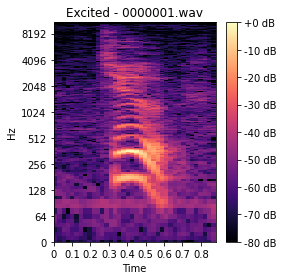

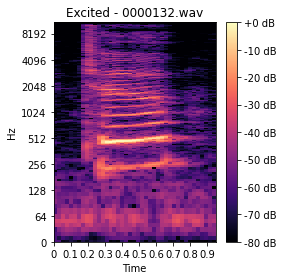

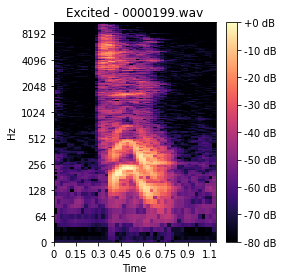

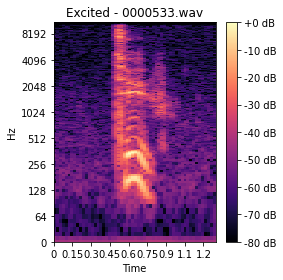

In [132]:
with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000001.wav') as audio:
    excited_waveform_01 = audio.read(dtype="float32")
    sample_rate = audio.samplerate

stft_spectrum_matrix = librosa.stft(excited_waveform_01)
plt.figure(figsize=(4, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Excited - 0000001.wav')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000132.wav') as audio:
    excited_waveform_132 = audio.read(dtype="float32")
    sample_rate = audio.samplerate

stft_spectrum_matrix = librosa.stft(excited_waveform_132)
plt.figure(figsize=(4, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Excited - 0000132.wav')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000199.wav') as audio:
    excited_waveform_199 = audio.read(dtype="float32")
    sample_rate = audio.samplerate

stft_spectrum_matrix = librosa.stft(excited_waveform_199)
plt.figure(figsize=(4, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Excited - 0000199.wav')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000533.wav') as audio:
    excited_waveform_533 = audio.read(dtype="float32")
    sample_rate = audio.samplerate

stft_spectrum_matrix = librosa.stft(excited_waveform_533)
plt.figure(figsize=(4, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Excited - 0000533.wav')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()


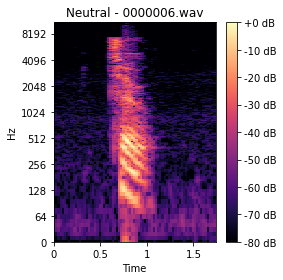

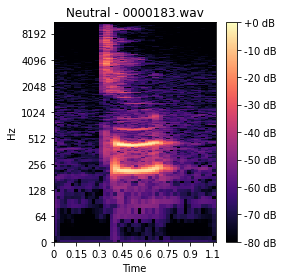

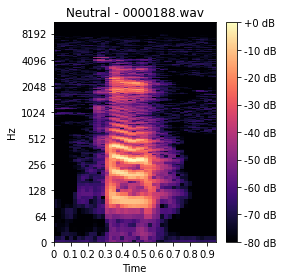

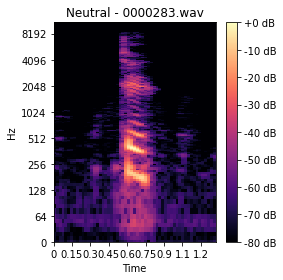

In [133]:
with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000006.wav') as audio:
    neutral_waveform_06 = audio.read(dtype="float32")
    sample_rate = audio.samplerate

stft_spectrum_matrix = librosa.stft(neutral_waveform_06)
plt.figure(figsize=(4, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Neutral - 0000006.wav')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000183.wav') as audio:
    excited_waveform_183 = audio.read(dtype="float32")
    sample_rate = audio.samplerate

stft_spectrum_matrix = librosa.stft(excited_waveform_183)
plt.figure(figsize=(4, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Neutral - 0000183.wav')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000188.wav') as audio:
    excited_waveform_188 = audio.read(dtype="float32")
    sample_rate = audio.samplerate

stft_spectrum_matrix = librosa.stft(excited_waveform_188)
plt.figure(figsize=(4, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Neutral - 0000188.wav')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000283.wav') as audio:
    excited_waveform_283 = audio.read(dtype="float32")
    sample_rate = audio.samplerate

stft_spectrum_matrix = librosa.stft(excited_waveform_283)
plt.figure(figsize=(4, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Neutral - 0000283.wav')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

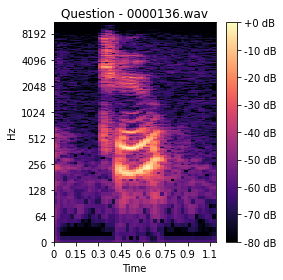

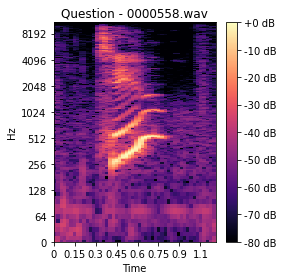

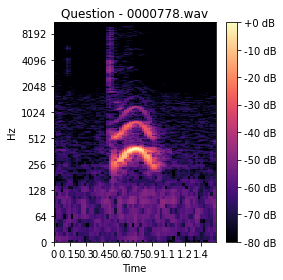

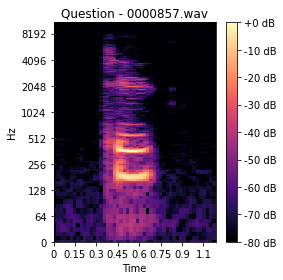

In [134]:
with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000136.wav') as audio:
    neutral_waveform_136 = audio.read(dtype="float32")
    sample_rate = audio.samplerate

stft_spectrum_matrix = librosa.stft(neutral_waveform_136)
plt.figure(figsize=(4, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Question - 0000136.wav')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000558.wav') as audio:
    neutral_waveform_558 = audio.read(dtype="float32")
    sample_rate = audio.samplerate

stft_spectrum_matrix = librosa.stft(neutral_waveform_558)
plt.figure(figsize=(4, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Question - 0000558.wav')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000778.wav') as audio:
    neutral_waveform_778 = audio.read(dtype="float32")
    sample_rate = audio.samplerate

stft_spectrum_matrix = librosa.stft(neutral_waveform_778)
plt.figure(figsize=(4, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Question - 0000778.wav')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

with soundfile.SoundFile('/content/drive/MyDrive/Data/MLEnd/training/Training/0000857.wav') as audio:
    neutral_waveform_857 = audio.read(dtype="float32")
    sample_rate = audio.samplerate

stft_spectrum_matrix = librosa.stft(neutral_waveform_857)
plt.figure(figsize=(4, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Question - 0000857.wav')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

Audio files are complex data types. Specifically they are **discrete signals** or **time series**, consisting of values on a 1D grid. These values are known as *samples* themselves, which might be a bit confusing, as we have used this term to refer to the *items* in our dataset. The **sampling frequency** is the rate at which samples in an audio file are produced. For instance a sampling frequency of 5HZ indicates that 5 produce 5 samples per second, or 1 sample every 0.2 s.

Let's plot one of our audio signals:

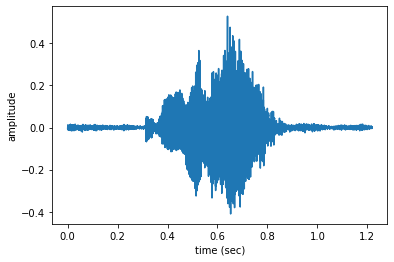

In [135]:
n=0
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

In [179]:
# Per numeral item count
numeral_df = labels.groupby('digit_label').size().reset_index(name='counts')
print("Total numerals recorded is ",numeral_df.shape[0])
p_count = labels.groupby('participant')['File ID'].size().reset_index(name='counts')

display(p_count)
print(p_count.shape)
print(numeral_df['counts'].mean())

Total numerals recorded is  32


,participant,counts
0,S1,111
1,S10,118
2,S100,150
3,S101,145
4,S102,66
...,...,...
179,S95,129
180,S96,133
181,S97,118
182,S98,35


(184, 2)
625.0


The file that we are listening to is:

In [177]:
files[n]

'/content/drive/MyDrive/Data/MLEnd/training/Training/0006970.wav'

Can you recognise the numeral and intonation? Compare them with the values for the numeral and intonation that you can find in the `labels` DataFrame. By changing the value of `n` in the previous cell, you can listen to other examples. If you are doing this during one of our lab sessions, please make sure that your mic is muted!

Exactly, how complex is an audio signal? Let's start by looking at the number of samples in one of our audio files:

In [140]:
n=0
x, fs = librosa.load(files[n],sr=fs)
print('This audio signal has', len(x), 'samples')

This audio signal has 26880 samples


## 1.3 Preprocessing

If we are using a raw audio signal as a predictor, we will be operating in a predictor space consisting of tens of thousands of dimensions. Compare this figure with the number of samples that we have. Do we have enough samples to train a model that takes one of these audio signals as an input?

One approach is to extract a few features from our signals and use these features instead as predictors. In the following cell, we define a function that extracts four features from an audio signal, namely:


1.   Power.
2.   Pitch mean.
3.   Pitch standard deviation.
4.   Fraction of voiced region.

In the next cell, we define a new function that gets the pitch of an audio signal.

In [141]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

Let's now consider the problem of identifying a numeral between 0 and 9. Then next cell defines a function that takes a number of files and creates a NumPy array containing the 4 audio features used as predictors (`X`) and their labels (`y`). 

In [142]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    label = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
    if onlySingleDigit and yi>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      mfccs = librosa.feature.mfcc(x, sr=fs)
      mfccs_processed = np.mean(mfccs.T,axis=0)

      zcr = np.mean(librosa.feature.zero_crossing_rate(x))
      spc =np.mean(librosa.feature.spectral_centroid(x,fs))
      spr= spc =np.mean(librosa.feature.spectral_rolloff(x,fs))

      stft_spectrogram=np.abs(librosa.stft(x))
      chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=fs).T,axis=0)

      melspectrogram=np.mean(librosa.feature.melspectrogram(y=x, sr=fs, n_mels=128, fmax=8000).T,axis=0)
      mfc_coefficients=np.mean(librosa.feature.mfcc(y=x, sr=fs, n_mfcc=40).T, axis=0)

      #xi = [power,pitch_mean,pitch_std,voiced_fr,zcr,spc,spr]
      xi = np.hstack((power,pitch_mean,pitch_std,voiced_fr,zcr,spc,spr,melspectrogram,chromagram,mfc_coefficients))
      #xi = [power,pitch_mean,pitch_std, voiced_fr, mfccs_processed]
      X.append(xi)
      y.append(label)
  return np.array(X),np.array(y)

Let's apply `getXy` to the first 500 files. Note that the first 500 files contains numerals outside the [0, 9] range, which we wil be discaarding.

In [ ]:
#X,y = getXy(files[:500],labels_file=labels,scale_audio=True, onlySingleDigit=True)
# If you want to use all 20000 files, run next line instead
X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=True)

The next cell shows the shape of `X` and `y` and prints the labels vector `y`:

In [144]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (6533, 187)
The shape of y is (6533,)
The labels vector is ['question' 'excited' 'question' ... 'neutral' 'bored' 'excited']


Finally, to be on the cautious side, let's eliminate any potential item with a NaN (*not a number*).

In [145]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X). sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))  

0


In [146]:
X_new = SelectKBest(mutual_info_classif, k=10).fit_transform(X, y)
X_new.shape

(6533, 10)

In [147]:
print(f'\nAudio samples represented: {X_new.shape[0]}')
print(f'Numerical features extracted per sample: {X_new.shape[1]}')
features_df = pd.DataFrame(X_new) # make it pretty for display
features_df


Audio samples represented: 6533
Numerical features extracted per sample: 10


,0,1,2,3,4,5,6,7,8,9
0,0.038618,187.723934,62.598813,0.291139,0.149539,2.223860,28.774933,19.269693,15.180964,0.841800
1,0.006295,130.283099,5.193614,0.241176,0.055512,17.704861,23.118090,0.253138,22.184542,0.171632
2,0.017070,171.916609,26.854425,0.111888,0.027110,0.056760,2.573255,3.888690,1.223087,0.039308
3,0.021679,165.671895,28.076065,0.588785,0.190692,7.393907,29.245216,234.789368,43.197720,0.132902
4,0.035376,105.684323,8.642074,0.275862,0.524670,1.139227,0.631895,3.920169,3.464180,0.002659
...,...,...,...,...,...,...,...,...,...,...
6528,0.009018,91.756479,4.841721,0.351351,4.724880,1.327333,1.590927,12.686323,17.916010,0.024960
6529,0.001317,100.207365,5.764493,0.118577,0.499115,0.623739,0.133731,0.151816,0.334008,0.118313
6530,0.013996,215.806897,36.278086,0.356322,0.047155,0.807142,5.852943,15.459899,1.720887,0.016327
6531,0.016071,110.298321,3.985236,0.337580,87.691658,241.357178,14.369766,0.285542,0.294122,0.152986


In [148]:
intonation_list = np.unique(y)
intonation_list

array(['bored', 'excited', 'neutral', 'question'], dtype='<U8')

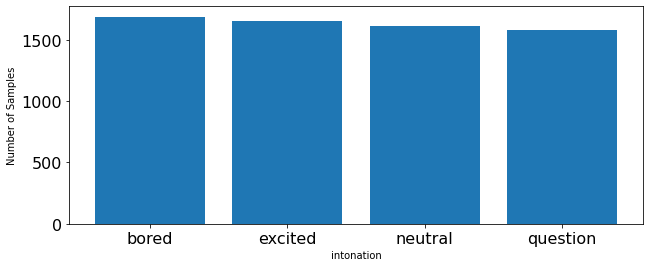

In [149]:
# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
intonation_list, count = np.unique(y, return_counts=True)
plt.bar(x=range(4), height=count)
plt.xticks(ticks=range(4), labels = [intonation for intonation in intonation_list],fontsize=10)
plt.xlabel('intonation')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

In [150]:
scaler = StandardScaler()
features_scaled = X_new
features_scaled = scaler.fit_transform(features_scaled)

In [151]:
features_scaled_df = pd.DataFrame(features_scaled) # make it pretty for display
features_scaled_df

,0,1,2,3,4,5,6,7,8,9
0,1.085250,0.140534,1.264882,-0.111465,-0.243579,-0.276342,0.031931,-0.062612,-0.155694,0.290726
1,-1.097510,-0.594932,-0.841772,-0.420614,-0.245314,-0.129779,-0.033022,-0.329298,-0.025889,-0.125897
2,-0.369886,-0.061861,-0.046864,-1.220598,-0.245838,-0.296858,-0.268923,-0.278313,-0.414391,-0.208159
3,-0.058651,-0.141817,-0.002032,1.730246,-0.242819,-0.227396,0.037331,2.959818,0.363570,-0.149975
4,0.866312,-0.909892,-0.715220,-0.205994,-0.236655,-0.286610,-0.291214,-0.277872,-0.372854,-0.230943
...,...,...,...,...,...,...,...,...,...,...
6528,-0.913650,-1.088222,-0.854685,0.261103,-0.159129,-0.284829,-0.280203,-0.154936,-0.105003,-0.217079
6529,-1.433721,-0.980018,-0.820821,-1.179209,-0.237126,-0.291491,-0.296934,-0.330719,-0.430869,-0.159044
6530,-0.577492,0.500105,0.298965,0.291859,-0.245468,-0.289754,-0.231265,-0.116040,-0.405164,-0.222445
6531,-0.437390,-0.850814,-0.886117,0.175889,1.372229,1.987597,-0.133473,-0.328844,-0.431608,-0.137489


## Model(s) description

### Support Vector Machines

Let's build a support vector machine (SVM) model for the predictive task of identifying digits in an audio signal, using the dataset that we have just created.

We will use the SVM method provided by `scikit-learn` and will split the dataset defined by `X` and `y` into a training set and a validation set.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((4573, 4), (1960, 4), (4573,), (1960,))

Can you identify the number of items in the training and validation sets?

Let's now fit an SVM model and print both the training accuracty and validation accuracy.

In [ ]:
model  = svm.SVC(C=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.47124425978569867
Validation  Accuracy 0.4857142857142857


Compare the training and validation accuracies. What do you observe? What do you think the accuracy of a random classifier would be?

Let's normalise the predictors, to see if the performance improves.

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(a,b,test_size=0.2)

mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model  = svm.SVC(C=1,gamma=2)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.6350317078504264
Validation  Accuracy 0.551530612244898


Once again, compare the training and validation accuracies. Do you think this classifier is better than the previous one? What could you do to build a better classifier?

### Comparing Classifiers

In [152]:
from sklearn.model_selection import train_test_split
 
X_train_scaled, X_test_scaled, y_train, y_val = train_test_split(
    features_scaled, 
    y, 
    test_size=0.2, 
    stratify=y
)

In [153]:
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
    features_scaled, 
    y, 
    test_size=0.2, 
    stratify=y
)

classification_models = [
    KNeighborsClassifier(),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train_scaled, y_train)
    score = model.score(X_val_scaled, y_val)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))
    
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

,Classifier,Accuracy Score
3,RandomForestClassifier,61.59%
1,SVC RBF kernel,57.46%
0,KNeighborsClassifier,55.09%
4,AdaBoostClassifier,52.72%
2,DecisionTreeClassifier,48.74%
6,QuadraticDiscriminantAnalysis,35.96%
5,GaussianNB,34.20%


### Hyper Parameter Tuning

In [ ]:
param_grid = { 'C':[1,2,3,4,5,6,7,8],'kernel':['rbf'],'gamma': [ 1, 0.1, 0.01 ]}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2, cv= 5)
grid.fit(X_train_scaled,y_train)
print(grid.best_params_)
print(grid.best_estimator_)
print('Test dataset accuracy of best hyperparameter setting: {0}.'.format(grid.score(X_val_scaled, y_val)))

In [155]:
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [200,250,280,300,350],
    'max_features': ['sqrt']
}

grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
grid.fit(X_train_scaled, y_train)

print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)
print('Test dataset accuracy (random forest classifier): {0}.'.format(grid.score(X_val_scaled, y_val)))

0.6293507277667487
{'max_features': 'sqrt', 'n_estimators': 350}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)
Test dataset accuracy (random forest classifier): 0.6350420811017597.


# 2 Advanced solution

In [156]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [157]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    label = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    if onlySingleDigit and yi>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      mfccs = librosa.feature.mfcc(x, sr=fs)
      mfccs_processed = np.mean(mfccs.T,axis=0)

      zcr = np.mean(librosa.feature.zero_crossing_rate(x))
      spc =np.mean(librosa.feature.spectral_centroid(x,fs))
      spr= spc =np.mean(librosa.feature.spectral_rolloff(x,fs))

      stft_spectrogram=np.abs(librosa.stft(x))
      chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=fs).T,axis=0)

      melspectrogram=np.mean(librosa.feature.melspectrogram(y=x, sr=fs, n_mels=128, fmax=8000).T,axis=0)
      mfc_coefficients=np.mean(librosa.feature.mfcc(y=x, sr=fs, n_mfcc=40).T, axis=0)

      #xi = [power,pitch_mean,pitch_std,voiced_fr,zcr,spc,spr]
      xi = np.hstack((power,pitch_mean,pitch_std,voiced_fr,zcr,spc,spr,melspectrogram,chromagram,mfc_coefficients))
      #xi = [power,pitch_mean,pitch_std, voiced_fr, mfccs_processed]
      X.append(xi)
      y.append(label)
  return np.array(X),np.array(y)

In [ ]:
#X,y = getXy(files[:500],labels_file=labels,scale_audio=True, onlySingleDigit=True)

# If you want to use all 20000 files, run next line instead
X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=True)

In [159]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (6533, 187)
The shape of y is (6533,)
The labels vector is [1 9 6 ... 4 7 8]


In [160]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif#

#X.shape
X_new = SelectKBest(mutual_info_classif, k=10).fit_transform(X, y)
X_new.shape

(6533, 10)

In [161]:
print(f'\nAudio samples represented: {X_new.shape[0]}')
print(f'Numerical features extracted per sample: {X_new.shape[1]}')
features_df = pd.DataFrame(X_new) # make it pretty for display
features_df


Audio samples represented: 6533
Numerical features extracted per sample: 10


,0,1,2,3,4,5,6,7,8,9
0,2.712338,19.130489,1.276163,2.548886,19.639297,28.238022,8.344509,2.289011,1.689268,2.482893
1,0.285037,0.006820,1.343456,0.342070,0.028804,0.016517,0.322909,0.529227,0.145819,0.071395
2,0.057502,0.041820,0.068963,0.058278,0.042908,0.011216,0.014170,0.011283,0.011737,0.016451
3,0.016331,0.009495,0.003345,0.005548,0.007536,0.004237,0.002789,0.015031,0.070993,0.053729
4,5.498236,11.317479,7.942002,3.396208,2.921979,1.337571,2.186323,3.107073,1.490896,0.766435
...,...,...,...,...,...,...,...,...,...,...
6528,0.851050,0.658682,1.757960,1.378860,0.897140,0.529438,0.513555,0.585109,0.532182,0.457369
6529,0.017189,0.018965,0.020454,0.018434,0.015716,0.013561,0.008850,0.011919,0.009667,0.016634
6530,2.723588,1.004639,0.223658,0.120846,0.511206,0.914122,1.197494,1.120860,0.820469,0.266196
6531,0.079390,0.050363,0.022217,0.038402,0.047961,0.127212,0.057999,0.018434,0.018643,0.055172


In [162]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
features_scaled = X_new
features_scaled = scaler.fit_transform(features_scaled)

In [163]:
features_scaled_df = pd.DataFrame(features_scaled) # make it pretty for display
features_scaled_df

,0,1,2,3,4,5,6,7,8,9
0,-0.018000,1.479028,-0.097216,0.052678,2.467857,3.670956,0.859542,0.091839,0.028333,0.333176
1,-0.237785,-0.227768,-0.091903,-0.180421,-0.240276,-0.227084,-0.175519,-0.147729,-0.175078,-0.246796
2,-0.258387,-0.224644,-0.192529,-0.210397,-0.238328,-0.227816,-0.215357,-0.218239,-0.192748,-0.260010
3,-0.262115,-0.227529,-0.197709,-0.215967,-0.243213,-0.228780,-0.216826,-0.217729,-0.184939,-0.251045
4,0.234254,0.781714,0.429075,0.142178,0.159261,-0.044616,0.064925,0.203206,0.002190,-0.079637
...,...,...,...,...,...,...,...,...,...,...
6528,-0.186534,-0.169589,-0.059177,-0.070908,-0.120362,-0.156237,-0.150919,-0.140122,-0.124159,-0.153968
6529,-0.262037,-0.226684,-0.196359,-0.214606,-0.242083,-0.227492,-0.216044,-0.218153,-0.193021,-0.259966
6530,-0.016981,-0.138712,-0.180315,-0.203789,-0.173658,-0.103104,-0.062668,-0.067187,-0.086166,-0.199946
6531,-0.256405,-0.223881,-0.196219,-0.212497,-0.237630,-0.211794,-0.209702,-0.217266,-0.191838,-0.250698


In [164]:
from sklearn.model_selection import train_test_split

# The labels/classes (y_train, y_test) never change, keep old values 
X_train_scaled, X_test_scaled, y_train, y_val = train_test_split(
    features_scaled, 
    y, 
    test_size=0.2, 
    stratify=y
)

In [ ]:
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [200,250,280,300,350],
    'max_features': ['sqrt']
}

grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
grid.fit(X_train_scaled, y_train)

print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)
print('Test dataset accuracy (random forest classifier): {0}.'.format(grid.score(X_val_scaled, y_val)))

0.6293507277667487
{'max_features': 'sqrt', 'n_estimators': 350}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)
Test dataset accuracy (random forest classifier): 0.6350420811017597.


In [167]:
# Convert features and corresponding classification labels into numpy arrays
#X = np.array(features_scaled_df.feature.tolist())
#y = np.array(features_scaled_df.class_label.tolist())
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [168]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)

In [169]:
num_labels = yy.shape[1]
filter_size = 2 
def build_model_graph(input_shape=(40,)):
    model = Sequential()
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return (model)
model = build_model_graph()

In [170]:
num_epochs = 100
num_batch_size = 32
model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

Epoch 1/100
164/164 [==============================] - 2s 6ms/step - loss: 392.6184 - accuracy: 0.1032 - val_loss: 2.3030 - val_accuracy: 0.0918
Epoch 2/100
164/164 [==============================] - 1s 4ms/step - loss: 5.6904 - accuracy: 0.1089 - val_loss: 2.3031 - val_accuracy: 0.0918
Epoch 3/100
164/164 [==============================] - 1s 4ms/step - loss: 3.0339 - accuracy: 0.0940 - val_loss: 2.3030 - val_accuracy: 0.0995
Epoch 4/100
164/164 [==============================] - 1s 4ms/step - loss: 2.7045 - accuracy: 0.1014 - val_loss: 2.3029 - val_accuracy: 0.0995
Epoch 5/100
164/164 [==============================] - 1s 4ms/step - loss: 2.5259 - accuracy: 0.1035 - val_loss: 2.3029 - val_accuracy: 0.0995
Epoch 6/100
164/164 [==============================] - 1s 4ms/step - loss: 2.4981 - accuracy: 0.1056 - val_loss: 2.3029 - val_accuracy: 0.0995
Epoch 7/100
164/164 [==============================] - 1s 4ms/step - loss: 2.4024 - accuracy: 0.0989 - val_loss: 2.3028 - val_accuracy: 0.09

In [171]:
# Display model architecture summary 
model.summary()
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 256)               48128     
_________________________________________________________________
activation_15 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_16 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)               

In [172]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

Training Accuracy: 10.20%
Testing Accuracy: 9.95%
